<a href="https://colab.research.google.com/github/BrittaEnte/udacity-dand-ab-test/blob/master/Analyze_ab_test_results_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ab_data.csv to ab_data.csv


In [ ]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [ ]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [ ]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [ ]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [ ]:
treatment = df.query("group == 'treatment' and landing_page == 'old_page'").count()[0]
control = df.query("group == 'control' and landing_page =='new_page'").count()[0]
print(control)
print(treatment)

1928
1965


In total 3893 items don´t line up. 

f. Do any of the rows have missing values?

In [ ]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [ ]:
df2 = df.query("(group == 'treatment' and landing_page == 'new_page') or (group == 'control' and landing_page == 'old_page')")

In [ ]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [ ]:
print(df2['user_id'].nunique())
print(df2.shape)

290584
(290585, 5)


b. There is one **user_id** repeated in **df2**.  What is it?

In [ ]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [ ]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [ ]:
# drop the duplicate
df2.drop(2893, inplace=True)
#recheck 
df2[df2['user_id'].duplicated()]
print(df2.shape)
# as to see we got now only 290584 rows and we deleted one row

KeyError: ignored

In [ ]:
print(df2.shape)

(290584, 5)


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [ ]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [ ]:
df2.query('group =="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [ ]:
df2.query('group =="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [ ]:
len(df2[df2['landing_page'] == 'new_page'])/len(df2)

0.5000619442226688

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

Null hypothesis (H0): the website visitors that are in the treatment group will not have higher end-of-visit conversion rates compares to visitors that are in the control group

Alternative hypothesis (H1): the website visitors that are in the treatment group will have higher end-of-visit conversion rates compares to visitors that are in the control group. 

so H0 = new page.converted <= old page converted
and the H1 would be = new page. converted > old page converted

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [ ]:
# old page and new page shall be equal in the converted rate
p_new = df2.converted.mean()
p_new


0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [ ]:
# old page and new page shall be equal in the converted rate
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [ ]:
# size of the new group
n_new = df2.query("group == 'treatment' ").shape[0]
n_new

145310

d. What is $n_{old}$?

In [ ]:
#size of the old group
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [ ]:
# binominal calculation 
new_page_converted = np.random.binomial(n_new , p_new)
new_page_converted

17603

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [ ]:
old_page_converted = np.random.binomial(n_old , p_old)
old_page_converted

17270

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [ ]:
diff = new_page_converted/n_new - old_page_converted/n_old
diff 

0.0022622005567438652

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [ ]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

#create an arraw 
p_diffs = np.array(diff)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5, 1.0, 'sample distribution for the conversion rate')

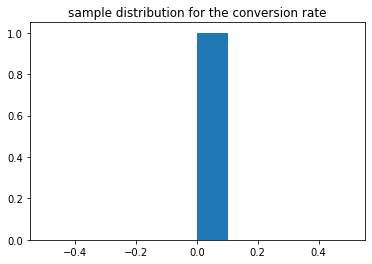

In [ ]:
#draw the histogramm. as to see the distribution is normal due to the central limit theorem. 
plt.hist(p_diffs)
plt.title("sample distribution for the conversion rate")
 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [ ]:
#calculate the obs-diff
obs_diff = df2.query('group =="treatment"').converted.mean() - df2.query('group =="control"').converted.mean()
obs_diff
# calculate the p value
p_value =(p_diffs > obs_diff).mean()
p_value

1.0

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

###### we calculated the p value. the p value is the probability of getting  the data or more extreme data if the null hypothesis is true.
######  if the p value is less than the alpha ( level of significance) than we must reject the null hypothesis. in our case the p value is high so we fail to reject the H0. the p value goes from 0 -1.
##### this means the new page is not better than the new page. we shall stay with the old page 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
import statsmodels.api as sm
# for the ztest we need 4 variables. the sum of new and old converted and the size of both groups. 
convert_old = df2.query('group == "control" & converted == 1').sum()
convert_new = df2.query('group == "treatment" & converted == 1').sum()
n_old = df2.query("group == 'control' ").shape[0]
n_new = df2.query("group == 'treatment' ").shape[0]

convert_new
n_new

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [ ]:
sm.stats.proportions_ztest([17489, 17264], [145274, 145310], alternative ="smaller")

#sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
# this function throws out an error. not int no float?? i don´t know. so i put the figures in the function 
# instead of the variables.

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

the results of our null hypothesis and our z test are the same. 
the Z-Score or Z-Value or Standard Score is the value of the distance between the mean of the distribution and the raw score calculated in standard deviation.
the p value on the other side is the probability of getting the data or more extreme data if the null hypothesis is true. 


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

### we got conversion or no conversion so we have  binary data, we must use the logistic regression. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
#set the intercept to 1
df2['intercept']=1
# produce a dummy variables. control shall be 0 and treatment shall be 1
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
# test if the dummy variables are there. 
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [ ]:
lm = sm.Logit(df2['converted'],df2[['intercept','treatment']])
result = lm.fit()
#provide a summary of your data. 
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:52:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

the null hypothesis and the z- test was a one tailed test. we just tested if the new page ogt less converted than the old page. however the  Logistic Regression performed was a two tailed test. a two tailed test is done in both directions, we search for any positive or negative results. so our p value in differs. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving countries.csv to countries.csv


In [ ]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
## in my original dataset we don´t have any country? so what does this method above?
df_new.head()
df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,1,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,0,1
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,1,0


In [ ]:
### Create the necessary dummy variables
df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]
# test the new dataset
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
### Fit Your Linear Model And Obtain the Results
lm2 = sm.Logit(df_new['converted'], df_new[["intercept", 'CA', 'US']])
results = lm2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        09:55:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

#### conclusion
######## looks like there is no big difference between our countries. the baseline is country uk. 

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

###### sources: khan academy ( hypothesis test, p value, ztest), youtube ( hypothesis test, p value, ztest)
###### sources : http://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html
###### sources : http://slideplayer.com/slide/6183997/18/images/8/Linear+versus+Logistic+ Regression.jpg
##### sources:  https://medium.com/@saahil1292/statistics-101-p-value-z-value-4fa0514a3e7d